## Import Libraries

In [ ]:
import tensorflow as tf #Training model
import matplotlib.pyplot as plt #Displaying images
import random #Randomly selecting images
from tqdm import tqdm #Progress bar

## Load dataset

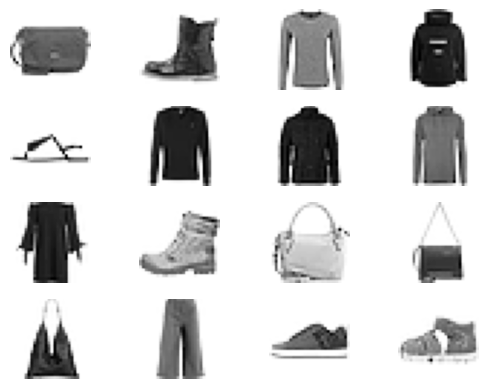

In [ ]:
(data, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data() #Loading data
data = (data - 127.5) / 127.5 #Normalizing data
data = data.reshape(data.shape[0], 28, 28, 1).astype('float32') #Reshaping data
#For loop to display images in a 4x4 grid
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(data[random.randint(0, data.shape[0])], cmap='Greys')
    plt.axis('off')
#Setting our input vector size
noise_dim=100

## Create generator Model

In [ ]:
generator = tf.keras.models.Sequential() #Create empty model

#Input Layer and reshaping to 7x7x256
generator.add(tf.keras.layers.Dense(7*7*256, input_shape=(noise_dim,), use_bias=False))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())
generator.add(tf.keras.layers.Reshape((7, 7, 256)))

#First Conv2DTranspose layer, reshaping to 14x14x100
generator.add(tf.keras.layers.Conv2DTranspose(100, (5, 5), strides=(1, 1), padding='same', use_bias=False))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

#Second Conv2DTranspose layer, reshaping to 28x28x64
generator.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.LeakyReLU())

#Final Conv2DTranspose layer, reshaping to 28x28x1, our image size
generator.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 100)         640000    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 100)         4

## Generate Images

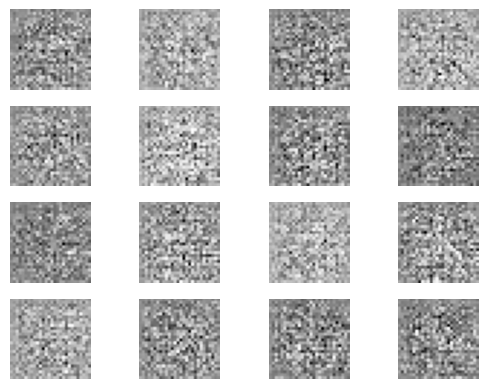

In [ ]:
generated_samples = generator(tf.random.normal([16, noise_dim]), training=False) #Generating 16 images
#For loop to display generated images in a 4x4 grid
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i, :, :, 0], cmap='Grays')
    plt.axis('off')

## Create discriminator

In [ ]:
discriminator = tf.keras.models.Sequential() #Create empty model

#First Conv2D layer, reshapes to 14x14x64
discriminator.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

#Second Conv2D layer, reshapes to 7x7x128
discriminator.add(tf.keras.layers.Conv2D(noise_dim, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(tf.keras.layers.LeakyReLU())
discriminator.add(tf.keras.layers.Dropout(0.3))

#Flatten and final Dense layer, for output
discriminator.add(tf.keras.layers.Flatten())
discriminator.add(tf.keras.layers.Dense(1))
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 100)         160100    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 100)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 100)         0         
                                                                 
 flatten (Flatten)           (None, 4900)             

In [ ]:
#Trying discriminator on generated images, using sigmoid to squish output between 0 and 1
tf.keras.activations.sigmoid(discriminator(generated_samples, training=False))

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[0.49995717],
       [0.50023896],
       [0.49963778],
       [0.5004614 ],
       [0.49991095],
       [0.50069815],
       [0.5002559 ],
       [0.4996887 ],
       [0.49968708],
       [0.49991196],
       [0.49998787],
       [0.49992684],
       [0.49985126],
       [0.49989238],
       [0.49964443],
       [0.50015664]], dtype=float32)>

## Create functions and parameters for training

In [ ]:
#Cross entropy loss function, from_logits=True because we are not using sigmoid activation
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#Discriminator loss function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) #Comparing real output to array of 1s, to get real loss
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) #Comparing fake output to array of 0s, to get fake loss
    return real_loss+fake_loss #Adding real and fake loss

#Generator loss function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) #Comparing fake output to array of 1s, to get generator loss

#Defining optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#Defining parameters for training
epochs=100 #training takes 3 hours, so you can scale down epochs and try with pre-trained models, linked all the way below
batch_size=64

## Training step function

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim]) #Generating noise
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #Using GradientTape to record operations for automatic differentiation
        generated_images = generator(noise, training=True) #Generating images
        real_output = discriminator(images, training=True) #testing discriminator on real images
        fake_output = discriminator(generated_images, training=True) #testing discriminator on generated images

        #Getting losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    #Getting gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #Using optimizers to apply gradients, on the model's trainable variables
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss #Returning losses, for checking progress

## Training our GAN

In [ ]:
#Create lists to store losses, for graphing later
gen_losses = []
disc_losses = []
#Creating dataset, shuffling and batching
train_dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(data.shape[0]).batch(batch_size)
#Define training loop
for epoch in range(epochs):
    #Go through batches, using tqdm to display progress bar, and train models
    for batch in tqdm(train_dataset, desc=f'Epoch {epoch+1}/{epochs}'):
        gen_loss, disc_loss = train_step(batch)

    #Append losses to lists
    gen_losses.append(gen_loss)
    disc_losses.append(disc_loss)

    #Print losses
    print(f'Generator Loss: {gen_loss}, Discriminator Loss: {disc_loss}')
    #Save generated images every 10 epochs
    if (epoch+1) % 10 == 0:
        generated_samples = generator(tf.random.normal([16, noise_dim]), training=False) #Generating 16 images
        #For loop to display generated images in a 4x4 grid
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(generated_samples[i, :, :, 0], cmap='Greys')
            plt.axis('off')
        plt.savefig(f'images/GAN_{epoch+1}.png') #Save image
        plt.clf() #Clear figure

Epoch 1/100: 100%|██████████| 938/938 [01:50<00:00,  8.50it/s]


Generator Loss: 0.7733043432235718, Discriminator Loss: 1.169622778892517


Epoch 2/100: 100%|██████████| 938/938 [02:07<00:00,  7.34it/s]


Generator Loss: 0.8449467420578003, Discriminator Loss: 1.5436583757400513


Epoch 3/100: 100%|██████████| 938/938 [01:55<00:00,  8.10it/s]


Generator Loss: 0.9024630784988403, Discriminator Loss: 1.158292293548584


Epoch 4/100: 100%|██████████| 938/938 [01:55<00:00,  8.14it/s]


Generator Loss: 1.3321056365966797, Discriminator Loss: 0.6772754192352295


Epoch 5/100: 100%|██████████| 938/938 [01:56<00:00,  8.08it/s]


Generator Loss: 1.1944273710250854, Discriminator Loss: 1.0873544216156006


Epoch 6/100: 100%|██████████| 938/938 [01:52<00:00,  8.32it/s]


Generator Loss: 1.1560068130493164, Discriminator Loss: 0.9149043560028076


Epoch 7/100: 100%|██████████| 938/938 [01:49<00:00,  8.53it/s]


Generator Loss: 1.1894216537475586, Discriminator Loss: 1.2897603511810303


Epoch 8/100: 100%|██████████| 938/938 [01:44<00:00,  8.96it/s]


Generator Loss: 1.6118783950805664, Discriminator Loss: 0.8715454339981079


Epoch 9/100: 100%|██████████| 938/938 [01:42<00:00,  9.13it/s]


Generator Loss: 1.2268210649490356, Discriminator Loss: 1.0830483436584473


Epoch 10/100: 100%|██████████| 938/938 [02:03<00:00,  7.61it/s]


Generator Loss: 1.4822173118591309, Discriminator Loss: 0.9883225560188293


Epoch 11/100: 100%|██████████| 938/938 [01:54<00:00,  8.20it/s]


Generator Loss: 1.0774376392364502, Discriminator Loss: 1.114684820175171


Epoch 12/100: 100%|██████████| 938/938 [01:48<00:00,  8.62it/s]


Generator Loss: 1.8208222389221191, Discriminator Loss: 0.666030764579773


Epoch 13/100: 100%|██████████| 938/938 [01:48<00:00,  8.65it/s]


Generator Loss: 1.4130477905273438, Discriminator Loss: 0.9128166437149048


Epoch 14/100: 100%|██████████| 938/938 [01:55<00:00,  8.12it/s]


Generator Loss: 1.4575328826904297, Discriminator Loss: 0.9760351181030273


Epoch 15/100: 100%|██████████| 938/938 [02:05<00:00,  7.50it/s]


Generator Loss: 1.0095163583755493, Discriminator Loss: 1.0756326913833618


Epoch 16/100: 100%|██████████| 938/938 [02:08<00:00,  7.31it/s]


Generator Loss: 1.1072733402252197, Discriminator Loss: 1.175479531288147


Epoch 17/100: 100%|██████████| 938/938 [01:48<00:00,  8.61it/s]


Generator Loss: 1.2118217945098877, Discriminator Loss: 1.0272984504699707


Epoch 18/100: 100%|██████████| 938/938 [01:50<00:00,  8.51it/s]


Generator Loss: 1.315802812576294, Discriminator Loss: 0.9575821161270142


Epoch 19/100: 100%|██████████| 938/938 [01:44<00:00,  8.95it/s]


Generator Loss: 1.2453869581222534, Discriminator Loss: 1.2580478191375732


Epoch 20/100: 100%|██████████| 938/938 [01:49<00:00,  8.53it/s]


Generator Loss: 1.058316946029663, Discriminator Loss: 1.0835154056549072


Epoch 21/100: 100%|██████████| 938/938 [01:53<00:00,  8.25it/s]


Generator Loss: 1.2870173454284668, Discriminator Loss: 1.3565059900283813


Epoch 22/100: 100%|██████████| 938/938 [01:54<00:00,  8.16it/s]


Generator Loss: 1.0618360042572021, Discriminator Loss: 1.1300567388534546


Epoch 23/100: 100%|██████████| 938/938 [01:51<00:00,  8.44it/s]


Generator Loss: 1.1135969161987305, Discriminator Loss: 1.1872713565826416


Epoch 24/100: 100%|██████████| 938/938 [01:36<00:00,  9.75it/s]


Generator Loss: 0.8920753002166748, Discriminator Loss: 1.1483078002929688


Epoch 25/100: 100%|██████████| 938/938 [01:36<00:00,  9.74it/s]


Generator Loss: 1.0066306591033936, Discriminator Loss: 1.1417236328125


Epoch 26/100: 100%|██████████| 938/938 [01:36<00:00,  9.75it/s]


Generator Loss: 1.0285224914550781, Discriminator Loss: 1.0007516145706177


Epoch 27/100: 100%|██████████| 938/938 [01:36<00:00,  9.73it/s]


Generator Loss: 1.0117682218551636, Discriminator Loss: 1.0515105724334717


Epoch 28/100: 100%|██████████| 938/938 [01:36<00:00,  9.74it/s]


Generator Loss: 1.0188217163085938, Discriminator Loss: 1.1694965362548828


Epoch 29/100: 100%|██████████| 938/938 [01:36<00:00,  9.71it/s]


Generator Loss: 1.0213000774383545, Discriminator Loss: 1.0561883449554443


Epoch 30/100: 100%|██████████| 938/938 [01:40<00:00,  9.35it/s]


Generator Loss: 0.9438230991363525, Discriminator Loss: 1.3045732975006104


Epoch 31/100: 100%|██████████| 938/938 [01:34<00:00,  9.96it/s]


Generator Loss: 1.0504281520843506, Discriminator Loss: 1.153223991394043


Epoch 32/100: 100%|██████████| 938/938 [01:35<00:00,  9.85it/s]


Generator Loss: 0.8586153984069824, Discriminator Loss: 1.1107265949249268


Epoch 33/100: 100%|██████████| 938/938 [01:52<00:00,  8.33it/s]


Generator Loss: 0.988704264163971, Discriminator Loss: 1.2320820093154907


Epoch 34/100: 100%|██████████| 938/938 [01:52<00:00,  8.32it/s]


Generator Loss: 0.9034267663955688, Discriminator Loss: 1.4861894845962524


Epoch 35/100: 100%|██████████| 938/938 [01:45<00:00,  8.89it/s]


Generator Loss: 1.0428276062011719, Discriminator Loss: 1.2101666927337646


Epoch 36/100: 100%|██████████| 938/938 [01:41<00:00,  9.24it/s]


Generator Loss: 0.8918179273605347, Discriminator Loss: 1.2691431045532227


Epoch 37/100: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]


Generator Loss: 0.9196063876152039, Discriminator Loss: 1.1365721225738525


Epoch 38/100: 100%|██████████| 938/938 [01:49<00:00,  8.58it/s]


Generator Loss: 0.8528245687484741, Discriminator Loss: 1.174477219581604


Epoch 39/100: 100%|██████████| 938/938 [01:43<00:00,  9.02it/s]


Generator Loss: 0.8833407759666443, Discriminator Loss: 1.2110884189605713


Epoch 40/100: 100%|██████████| 938/938 [01:47<00:00,  8.76it/s]


Generator Loss: 0.9750935435295105, Discriminator Loss: 1.3003745079040527


Epoch 41/100: 100%|██████████| 938/938 [01:40<00:00,  9.30it/s]


Generator Loss: 0.8895891904830933, Discriminator Loss: 1.2936053276062012


Epoch 42/100: 100%|██████████| 938/938 [01:44<00:00,  8.95it/s]


Generator Loss: 0.8822252750396729, Discriminator Loss: 1.3043262958526611


Epoch 43/100: 100%|██████████| 938/938 [01:45<00:00,  8.93it/s]


Generator Loss: 0.9939924478530884, Discriminator Loss: 1.2346627712249756


Epoch 44/100: 100%|██████████| 938/938 [01:44<00:00,  8.94it/s]


Generator Loss: 1.05500066280365, Discriminator Loss: 1.3056881427764893


Epoch 45/100: 100%|██████████| 938/938 [01:38<00:00,  9.48it/s]


Generator Loss: 0.9968020915985107, Discriminator Loss: 1.1215741634368896


Epoch 46/100: 100%|██████████| 938/938 [01:44<00:00,  8.95it/s]


Generator Loss: 0.7228897213935852, Discriminator Loss: 1.295651912689209


Epoch 47/100: 100%|██████████| 938/938 [01:46<00:00,  8.81it/s]


Generator Loss: 0.9388975501060486, Discriminator Loss: 1.2928440570831299


Epoch 48/100: 100%|██████████| 938/938 [01:41<00:00,  9.22it/s]


Generator Loss: 1.0608808994293213, Discriminator Loss: 1.2517971992492676


Epoch 49/100: 100%|██████████| 938/938 [01:47<00:00,  8.71it/s]


Generator Loss: 0.9121416807174683, Discriminator Loss: 1.1631669998168945


Epoch 50/100: 100%|██████████| 938/938 [01:46<00:00,  8.79it/s]


Generator Loss: 1.063056230545044, Discriminator Loss: 1.0184705257415771


Epoch 51/100: 100%|██████████| 938/938 [02:02<00:00,  7.64it/s]


Generator Loss: 1.0858259201049805, Discriminator Loss: 1.4597043991088867


Epoch 52/100: 100%|██████████| 938/938 [01:59<00:00,  7.82it/s]


Generator Loss: 0.9234640598297119, Discriminator Loss: 1.159048080444336


Epoch 53/100: 100%|██████████| 938/938 [01:54<00:00,  8.17it/s]


Generator Loss: 0.926891565322876, Discriminator Loss: 1.2692675590515137


Epoch 54/100: 100%|██████████| 938/938 [01:51<00:00,  8.40it/s]


Generator Loss: 0.9327471852302551, Discriminator Loss: 1.2770843505859375


Epoch 55/100: 100%|██████████| 938/938 [01:47<00:00,  8.73it/s]


Generator Loss: 0.8364816904067993, Discriminator Loss: 1.2068384885787964


Epoch 56/100: 100%|██████████| 938/938 [01:47<00:00,  8.71it/s]


Generator Loss: 0.9923227429389954, Discriminator Loss: 1.2147347927093506


Epoch 57/100: 100%|██████████| 938/938 [01:53<00:00,  8.23it/s]


Generator Loss: 0.9731377959251404, Discriminator Loss: 1.1519067287445068


Epoch 58/100: 100%|██████████| 938/938 [02:01<00:00,  7.73it/s]


Generator Loss: 0.8717550039291382, Discriminator Loss: 1.3206627368927002


Epoch 59/100: 100%|██████████| 938/938 [02:01<00:00,  7.71it/s]


Generator Loss: 0.941860020160675, Discriminator Loss: 1.332785964012146


Epoch 60/100: 100%|██████████| 938/938 [01:59<00:00,  7.84it/s]


Generator Loss: 0.8184889554977417, Discriminator Loss: 1.2661643028259277


Epoch 61/100: 100%|██████████| 938/938 [02:05<00:00,  7.48it/s]


Generator Loss: 0.8690124750137329, Discriminator Loss: 1.242452621459961


Epoch 62/100: 100%|██████████| 938/938 [01:55<00:00,  8.11it/s]


Generator Loss: 0.8102294206619263, Discriminator Loss: 1.3889328241348267


Epoch 63/100: 100%|██████████| 938/938 [01:55<00:00,  8.12it/s]


Generator Loss: 0.7834557294845581, Discriminator Loss: 1.381034255027771


Epoch 64/100: 100%|██████████| 938/938 [01:54<00:00,  8.16it/s]


Generator Loss: 1.8281471729278564, Discriminator Loss: 1.1027802228927612


Epoch 65/100: 100%|██████████| 938/938 [01:55<00:00,  8.13it/s]


Generator Loss: 1.2315335273742676, Discriminator Loss: 1.1935151815414429


Epoch 66/100: 100%|██████████| 938/938 [01:54<00:00,  8.18it/s]


Generator Loss: 0.9079169034957886, Discriminator Loss: 1.3106080293655396


Epoch 67/100: 100%|██████████| 938/938 [01:54<00:00,  8.19it/s]


Generator Loss: 1.000934362411499, Discriminator Loss: 1.2233986854553223


Epoch 68/100: 100%|██████████| 938/938 [01:55<00:00,  8.09it/s]


Generator Loss: 0.9537943005561829, Discriminator Loss: 1.1568738222122192


Epoch 69/100: 100%|██████████| 938/938 [01:59<00:00,  7.82it/s]


Generator Loss: 0.8382670283317566, Discriminator Loss: 1.3261544704437256


Epoch 70/100: 100%|██████████| 938/938 [02:00<00:00,  7.77it/s]


Generator Loss: 0.7077895998954773, Discriminator Loss: 1.4256577491760254


Epoch 71/100: 100%|██████████| 938/938 [01:56<00:00,  8.06it/s]


Generator Loss: 0.8263134956359863, Discriminator Loss: 1.256789207458496


Epoch 72/100: 100%|██████████| 938/938 [01:58<00:00,  7.92it/s]


Generator Loss: 0.8599244952201843, Discriminator Loss: 1.2430813312530518


Epoch 73/100: 100%|██████████| 938/938 [02:03<00:00,  7.57it/s]


Generator Loss: 0.8920716047286987, Discriminator Loss: 1.2099521160125732


Epoch 74/100: 100%|██████████| 938/938 [02:05<00:00,  7.47it/s]


Generator Loss: 0.7717510461807251, Discriminator Loss: 1.2958489656448364


Epoch 75/100: 100%|██████████| 938/938 [02:29<00:00,  6.28it/s]


Generator Loss: 0.8297387957572937, Discriminator Loss: 1.2484008073806763


Epoch 76/100: 100%|██████████| 938/938 [02:17<00:00,  6.82it/s]


Generator Loss: 0.793086051940918, Discriminator Loss: 1.191145896911621


Epoch 77/100: 100%|██████████| 938/938 [01:51<00:00,  8.40it/s]


Generator Loss: 0.879760205745697, Discriminator Loss: 1.3777544498443604


Epoch 78/100: 100%|██████████| 938/938 [01:55<00:00,  8.12it/s]


Generator Loss: 0.9077367782592773, Discriminator Loss: 1.228069543838501


Epoch 79/100: 100%|██████████| 938/938 [01:59<00:00,  7.84it/s]


Generator Loss: 0.9575031995773315, Discriminator Loss: 1.2458686828613281


Epoch 80/100: 100%|██████████| 938/938 [02:12<00:00,  7.06it/s]


Generator Loss: 1.0181050300598145, Discriminator Loss: 1.190176248550415


Epoch 81/100: 100%|██████████| 938/938 [02:07<00:00,  7.34it/s]


Generator Loss: 0.7498384714126587, Discriminator Loss: 1.3354363441467285


Epoch 82/100: 100%|██████████| 938/938 [02:03<00:00,  7.60it/s]


Generator Loss: 0.849786639213562, Discriminator Loss: 1.3355286121368408


Epoch 83/100: 100%|██████████| 938/938 [01:58<00:00,  7.90it/s]


Generator Loss: 0.7823305130004883, Discriminator Loss: 1.34932279586792


Epoch 84/100: 100%|██████████| 938/938 [01:50<00:00,  8.49it/s]


Generator Loss: 0.9058147072792053, Discriminator Loss: 1.2718642950057983


Epoch 85/100: 100%|██████████| 938/938 [01:53<00:00,  8.23it/s]


Generator Loss: 0.8218825459480286, Discriminator Loss: 1.2570936679840088


Epoch 86/100: 100%|██████████| 938/938 [01:52<00:00,  8.33it/s]


Generator Loss: 0.8266566395759583, Discriminator Loss: 1.2724028825759888


Epoch 87/100: 100%|██████████| 938/938 [01:52<00:00,  8.37it/s]


Generator Loss: 0.7710224986076355, Discriminator Loss: 1.3673837184906006


Epoch 88/100: 100%|██████████| 938/938 [01:52<00:00,  8.36it/s]


Generator Loss: 0.857848048210144, Discriminator Loss: 1.29652738571167


Epoch 89/100: 100%|██████████| 938/938 [01:50<00:00,  8.48it/s]


Generator Loss: 0.8300378322601318, Discriminator Loss: 1.2687076330184937


Epoch 90/100: 100%|██████████| 938/938 [01:52<00:00,  8.37it/s]


Generator Loss: 0.6701478958129883, Discriminator Loss: 1.345277190208435


Epoch 91/100: 100%|██████████| 938/938 [02:03<00:00,  7.62it/s]


Generator Loss: 0.8388318419456482, Discriminator Loss: 1.34893798828125


Epoch 92/100: 100%|██████████| 938/938 [02:04<00:00,  7.50it/s]


Generator Loss: 0.7442021369934082, Discriminator Loss: 1.4431917667388916


Epoch 93/100: 100%|██████████| 938/938 [01:50<00:00,  8.51it/s]


Generator Loss: 0.8691590428352356, Discriminator Loss: 1.3137047290802002


Epoch 94/100: 100%|██████████| 938/938 [01:53<00:00,  8.30it/s]


Generator Loss: 0.7928701639175415, Discriminator Loss: 1.3299787044525146


Epoch 95/100: 100%|██████████| 938/938 [02:04<00:00,  7.54it/s]


Generator Loss: 0.8384037017822266, Discriminator Loss: 1.3671472072601318


Epoch 96/100: 100%|██████████| 938/938 [01:58<00:00,  7.94it/s]


Generator Loss: 0.8952372074127197, Discriminator Loss: 1.3287948369979858


Epoch 97/100: 100%|██████████| 938/938 [02:01<00:00,  7.73it/s]


Generator Loss: 0.8010585308074951, Discriminator Loss: 1.2938189506530762


Epoch 98/100: 100%|██████████| 938/938 [01:48<00:00,  8.66it/s]


Generator Loss: 0.8260456919670105, Discriminator Loss: 1.1082144975662231


Epoch 99/100: 100%|██████████| 938/938 [01:51<00:00,  8.43it/s]


Generator Loss: 0.8068082332611084, Discriminator Loss: 1.3468561172485352


Epoch 100/100: 100%|██████████| 938/938 [02:08<00:00,  7.31it/s]


Generator Loss: 0.8296851515769958, Discriminator Loss: 1.2841084003448486


<Figure size 640x480 with 0 Axes>

## Plot Losses

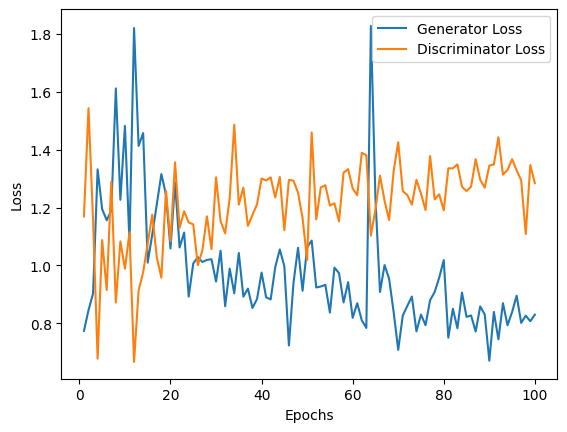

In [ ]:
plt.plot(range(1, epochs+1), gen_losses, label='Generator Loss') #graph generator loss
plt.plot(range(1, epochs+1), disc_losses, label='Discriminator Loss') #graph discriminator loss
#label graph
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Generating images

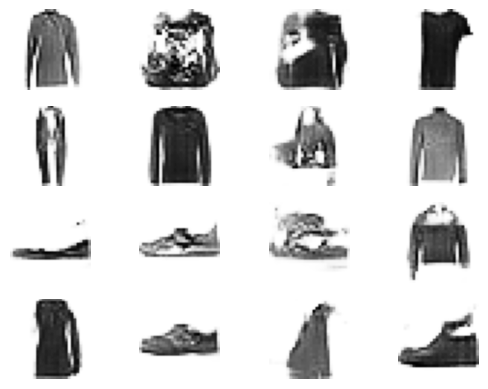

In [ ]:
generated_samples = generator(tf.random.normal([16, noise_dim]), training=False) #Generating 16 images
#For loop to display generated images in a 4x4 grid
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i, :, :, 0], cmap='Grays')
    plt.axis('off')
#save final image and display
plt.savefig(f'images/GAN_Final.png')

## Saving models

In [ ]:
generator.save('generator.h5') #save generator model
discriminator.save('discriminator.h5') #save discriminator model

## Load models and test

<tf.Tensor: shape=(16, 1), dtype=float32, numpy=
array([[0.3573441 ],
       [0.2584649 ],
       [0.42903212],
       [0.42065108],
       [0.4324449 ],
       [0.44114378],
       [0.46580362],
       [0.520774  ],
       [0.40393636],
       [0.5717225 ],
       [0.39975923],
       [0.4041469 ],
       [0.3965831 ],
       [0.38763344],
       [0.4687027 ],
       [0.39439097]], dtype=float32)>

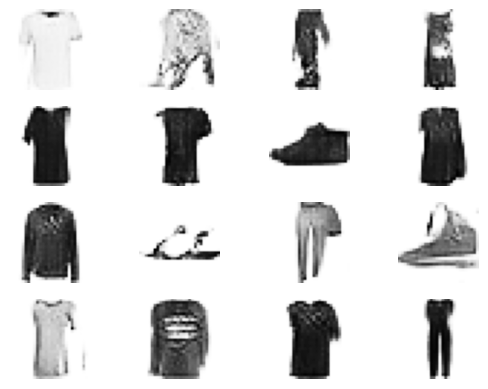

In [ ]:
#load models
new_generator = tf.keras.models.load_model('generator.h5')
new_discriminator = tf.keras.models.load_model('discriminator.h5')
generated_samples = new_generator(tf.random.normal([16, noise_dim]), training=False) #Generating 16 images
#For loop to display generated images in a 4x4 grid
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i, :, :, 0], cmap='Grays')
    plt.axis('off')
#print discriminator output
tf.keras.activations.sigmoid(new_discriminator(generated_samples, training=False))

Download pre-trained models here: https://drive.google.com/drive/folders/1RVy9Y2CEnLpAGwCx5miK5IajfRTGivNT?usp=sharing